# Automatic Differentiation of PDE solvers with JAX and dolfin-adjoint

Derivative information is the crucial requirement for using effective algorithms for design optimization, parameter estimation, optimal control, model
reduction and experimental design, and other tasks. This notebook gives an example how to use JAX together with FEniCS and dolfin-adjoint for computing derivatives.

## Poisson equation
The Poisson equation is the canonical elliptic partial differential equation. For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial \Omega = \Gamma_{D}$, the Poisson equation with particular boundary conditions reads:

$$\begin{align*} - \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\ u &= 0 \quad {\rm on} \ \Gamma_{D}. \\ \end{align*}$$
Here, $f$ is input data. The most standard variational form of Poisson equation reads: find $u \in V$ such that

$$\begin{equation*} a(u, v) = L(v) \quad \forall \ v \in V, \end{equation*}$$
where $V$ is a suitable function space and

$$\begin{align*} a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\ L(v) &= \int_{\Omega} f v \, {\rm d} x. \end{align*}$$




In [1]:
# Let's import all needed stuff
import jax
from jax.config import config

import jax.numpy as np
import numpy as onp

from scipy.optimize import minimize

# Library for automated PDE solution
import fenics
# Library for automated derivative computation of FEniCS programs
import fenics_adjoint
# UFL is domain specific language (DSL) for declaration of finite element discretizations of variational forms
import ufl 

# Suppress JIT compile message from FEniCS
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)

# This is the core function here
from jaxfenics_adjoint import build_jax_fem_eval
from jaxfenics_adjoint import numpy_to_fenics, fenics_to_numpy

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
# fenics.set_log_level(fenics.LogLevel.ERROR)

PDEs are spatial models and require a domain to be defined on. Here we choose the domain to be a unit square and it is triangulated for finite element discretization.

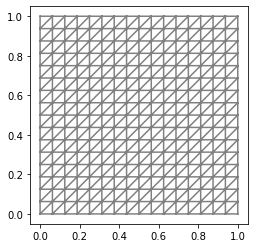

In [2]:
# Create mesh
n = 16
mesh = fenics_adjoint.UnitSquareMesh(n, n)
fenics.plot(mesh)

Another important part of the Poisson variational problem was the function space $V$. This object is resposible for representation of the disretized functions on the chosen mesh. Here we choose the function space to consist of piece-wise linear functions (P1 in finite element terminology, or CG1 for Continuous Galerkin of degree 1). DG corresponds to Discontinuous Galerkin function space. DG0 is piece-wise constant function in each mesh element. If the mesh was consisting of quads then it would be similar to pixel image.

In [3]:
# Define discrete function spaces and functions
V = fenics.FunctionSpace(mesh, "CG", 1)
W = fenics.FunctionSpace(mesh, "DG", 0)

JAX-FEniCS interface needs to auxilary information for being able to freely convert data between the libraries, therefore we need "templates" which represent what is the expected input to FEniCS function.

In [4]:
solve_templates = (fenics_adjoint.Function(W),)

Now we define the `fenics_solve` function which takes a function `f` which lives in the function space `W` and outputs the solution `u` to the Poisson equation.

`build_jax_fem_eval` is a wrapper decorator that registers `fenics_solve` for JAX.

In [5]:
# Define and solve the Poisson equation
@build_jax_fem_eval(solve_templates)
def fenics_solve(f):
    u = fenics.TrialFunction(V)
    v = fenics.TestFunction(V)
    inner, grad, dx = ufl.inner, ufl.grad, ufl.dx
    # Compare this code to the mathematical formulation above
    a = inner(grad(u), grad(v)) * dx
    L = f * v * dx
    bcs = fenics_adjoint.DirichletBC(V, 0.0, "on_boundary")
    u = fenics_adjoint.Function(V, name="PDE Solution")
    fenics_adjoint.solve(a == L, u, bcs)
    return u

In [6]:
# Let's create a vector of ones with size equal to the number of cells in the mesh
f = np.ones(W.dim())
# and solve the Poisson equation for given `f`
u = fenics_solve(f) # u is JAX's array

/u/65/yashchi1/unix/.conda/envs/fenicsproject/lib/python3.8/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


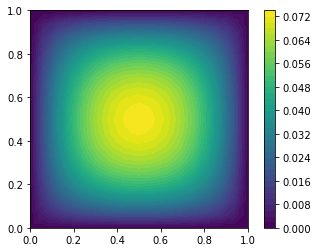

In [7]:
 # We need to explicitly provide the template function for conversion to FEniCS
u_fenics = numpy_to_fenics(u, fenics.Function(V))
c = fenics.plot(u_fenics)
plt.colorbar(c)

Here comes the JAX specific part. Having defined a mapping from $f$ to $u$ we can differentiate it. For example calculating vector-Jacobian product with `jax.vjp`:

In [8]:
%%time
u, vjp_fun = jax.vjp(fenics_solve, f)
g = np.ones_like(u)
vjp_result = vjp_fun(g)

CPU times: user 40.7 ms, sys: 665 µs, total: 41.4 ms
Wall time: 41.5 ms


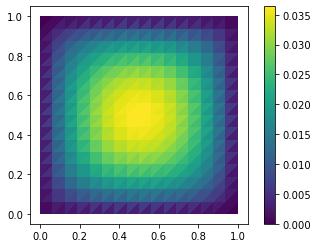

In [9]:
vjp_result_fenics = numpy_to_fenics(*vjp_result, fenics.Function(W))
c = fenics.plot(vjp_result_fenics)
plt.colorbar(c)

It is also possible to calculate the full (dense) Jacobian matrix $\frac{du}{df}$ with `jax.jacrev`:

In [10]:
%%time
dudf = jax.jacrev(fenics_solve)(f)

CPU times: user 2.74 s, sys: 35.2 ms, total: 2.78 s
Wall time: 2.71 s


In [11]:
# function `fenics_solve` maps R^200 (dimension of W) to R^121 (dimension of V)
# therefore the Jacobian matrix dimension is dim V x dim W
assert dudf.shape == (V.dim(), W.dim())

The same Jacobian matrix can be calculated using finite-differences, for example with `fdm` library. However, it takes considerably more time because it requires a lot of `fenics_solve` calls. The difference is even more drastic for larger models.

`jaxfenics_adjoint` library makes it possible to combine FEniCS programs with arbitrary JAX programs. In above example `f` could be the output of a neural network and passed as an input to the PDE solver or `u` could be further processed in JAX for evaluating functionals that are not integrals over the domain (this case can be handled in FEniCS).

In [12]:
# stax is JAX's mini-library for neural networks
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu
from jax import random

# Use stax to set up network initialization and evaluation functions
# Define R^2 -> R^1 function
net_init, net_apply = stax.serial(
    Dense(2), Relu,
    Dense(10), Relu,
    Dense(1), 
)

# Initialize parameters, not committing to a batch shape
rng = random.PRNGKey(0)
in_shape = (-1, 2)
out_shape, net_params = net_init(rng, in_shape)

# Apply network to dummy inputs
predictions = net_apply(net_params, W.tabulate_dof_coordinates())
source_nn = numpy_to_fenics(predictions, fenics.Function(W))

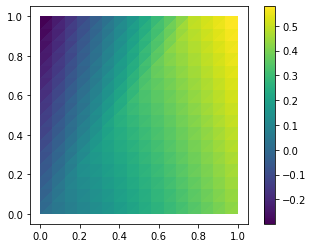

In [13]:
# Plot neural network prediction
c = fenics.plot(source_nn)
plt.colorbar(c)

In [14]:
def eval_nn(net_params):
    f_nn = np.ravel(net_apply(net_params, W.tabulate_dof_coordinates()))
    u = fenics_solve(f_nn)
    norm_u = np.linalg.norm(u)
    return norm_u

In [15]:
%%time
jax.grad(eval_nn)(net_params)

CPU times: user 423 ms, sys: 8.33 ms, total: 431 ms
Wall time: 422 ms


[(DeviceArray([[ 0.11934833, -0.08526856],
               [ 0.11315436, -0.16367367]], dtype=float32),
  DeviceArray([ 0.22669935, -0.25705874], dtype=float32)),
 (),
 (DeviceArray([[ 0.0000000e+00,  0.0000000e+00,  3.4377411e-01,
                -3.8510424e-01,  4.1671190e-02,  0.0000000e+00,
                 2.8023928e-01, -2.3091170e-06, -4.5939538e-01,
                 0.0000000e+00],
               [ 0.0000000e+00,  0.0000000e+00,  1.2621611e-02,
                -1.4139040e-02,  1.5299511e-03,  0.0000000e+00,
                 1.0288941e-02, -3.4431054e-08, -1.6866626e-02,
                 0.0000000e+00]], dtype=float32),
  DeviceArray([-0.0000000e+00, -0.0000000e+00,  3.9731458e-01,
               -4.4508159e-01,  4.8161194e-02,  0.0000000e+00,
                3.2388464e-01, -3.3104476e-05, -5.3094304e-01,
                0.0000000e+00], dtype=float32)),
 (),
 (DeviceArray([[0.00000000e+00],
               [0.00000000e+00],
               [2.40548089e-01],
               [1.174047

For further FEniCS examples check out [FEniCS' demos](https://bitbucket.org/fenics-project/dolfin/src/master/python/demo/documented/) and [dolfin-adjoint webiste](http://www.dolfin-adjoint.org/en/latest/documentation/examples.html).

For further examples on using FEniCS with JAX check out [`examples/` folder here](https://github.com/IvanYashchuk/jax-fenics-adjoint/tree/master/examples).